<a href="https://colab.research.google.com/github/RH00000/Rice_LLM_Replicability_Project/blob/main/prompt_ensembling_50_rpp_studies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q google-generativeai pandas openpyxl

In [ ]:
#import
from google import genai
import os
import requests
import pandas as pd
import re
import time
from google.colab import files, userdata
userdata.get('GEMINI_API_KEY')

In [3]:
#Initialize Gemini Client
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

In [5]:
#Upload and Load Excel File
uploaded = files.upload()
excel_file = list(uploaded.keys())[0]
df = pd.read_excel(excel_file, sheet_name=0).dropna(how="all")

Saving data_for_prompt_5_ensembling.xlsx to data_for_prompt_5_ensembling.xlsx


In [6]:
# List of required ensemble‑prompt columns
prompt_cols = [
    "sample_size_prompt",
    "p_value_prompt",
    "method_complexity_prompt",
    "author_citation_prompt",
    "subfield_prompt"
]

# Ensure they all exist
missing = [col for col in prompt_cols if col not in df.columns]
if missing:
    raise KeyError(f"Excel is missing the following prompt columns: {', '.join(missing)}")
else:
    print("All ensemble prompt columns exist:", ", ".join(prompt_cols))


All ensemble prompt columns exist: sample_size_prompt, p_value_prompt, method_complexity_prompt, author_citation_prompt, subfield_prompt


In [7]:
#Helper to extract probability from first line
def extract_prob(text):
    first_line = text.strip().splitlines()[0]
    m = re.search(r"\b(0(?:\.\d+)?|1(?:\.0+)?)\b", first_line)
    return float(m.group(0)) if m else None

In [10]:
# Prepare storage for each prompt's probs + avg + outputs
per_prompt_probs = {col.replace("_prompt", "_prob"): [] for col in prompt_cols}
avg_probs = []
outputs = []

# Resume support (unchanged)
autosave_file = 'autosave_file'
start_idx = 0
if os.path.exists(autosave_file):
    try:
        saved = pd.read_csv(autosave_file)
        start_idx = len(saved)
        if start_idx > 0:
            avg_probs = saved["replication_probability"].tolist()
            outputs   = saved["model_output"].tolist()
            for prob_col in per_prompt_probs:
                per_prompt_probs[prob_col] = saved[prob_col].tolist()
    except Exception as e:
        print(f"Error loading autosave file: {e}. Starting fresh.")
        start_idx = 0
        avg_probs, outputs = [], []
        for prob_col in per_prompt_probs:
            per_prompt_probs[prob_col] = []

if start_idx > 0:
    print(f"Resuming from row {start_idx}")

# Main loop
for idx in df.index[start_idx:]:
    this_probs   = []
    this_outputs = []

    # for each of the 5 prompts
    for col in prompt_cols:
        prompt = df.at[idx, col]
        try:
            response = client.models.generate_content(
                model="gemini-2.5-pro",
                contents=[prompt]
            )
            text = response.candidates[0].content.parts[0].text.strip()
            prob = extract_prob(text) or 0.0
        except Exception as e:
            text = f"Error: {e}"
            prob = 0.0

        this_probs.append(prob)
        this_outputs.append(text)

        # append to the per‑prompt list
        key = col.replace("_prompt", "_prob")
        per_prompt_probs[key].append(prob)

        time.sleep(2.0)  # rate limit

    # average and append
    avg = sum(this_probs) / len(this_probs)
    avg_probs.append(avg)
    outputs.append("\n---\n".join(this_outputs))

    # autosave every 10
    if len(avg_probs) % 10 == 0:
        df_partial = df.iloc[:len(avg_probs)].copy()
        # assign all prob columns
        for key, lst in per_prompt_probs.items():
            df_partial[key] = lst
        df_partial["replication_probability"] = avg_probs
        df_partial["model_output"]            = outputs
        df_partial.to_csv(autosave_file, index=False)
        print(f"Autosaved through row {len(avg_probs)-1}")

# Write back to df
for key, lst in per_prompt_probs.items():
    df[key] = lst
df["replication_probability"] = avg_probs
df["model_output"]            = outputs

# Final save
df.to_csv("predictions_output_final.csv", index=False)
files.download("predictions_output_final.csv")

Autosaved through row 9
Autosaved through row 19
Autosaved through row 29
Autosaved through row 39
Autosaved through row 49
Autosaved through row 59
Autosaved through row 69
Autosaved through row 79
Autosaved through row 89
Autosaved through row 99


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#OMFG IM GONNA CRASH OUT RAN THIS FOR 4 HOURS AND STILL GOT UNAVAILABLE... HOW MUCH DO YOU WANT ME TO PAY GOOGLE?????

In [11]:
!pip install -q scikit-learn

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

In [13]:
df_result = pd.read_csv("predictions_output_final.csv")

In [14]:
# Drop rows with any zero in the individual prompt probabilities
prob_cols = [
    "sample_size_prob",
    "p_value_prob",
    "method_complexity_prob",
    "author_citation_prob",
    "subfield_prob"
]

# Remove rows with 0 in any of the five prompt probabilities
df_filtered = df_result.copy()
for col in prob_cols:
    df_filtered = df_filtered[df_filtered[col] != 0]

# Drop rows where "replication_probability" is blank
df_filtered = df_filtered.dropna(subset=["replication_probability"]).copy()

# Convert replication_probability to float
df_filtered["replication_probability"] = df_filtered["replication_probability"].astype(float)

# Convert ground truth to binary labels
df_filtered["replicated"] = df_filtered["Result (replicated?)"].str.strip().str.lower().map({"yes": 1, "no": 0})


In [15]:
# Compute AUC
auc = roc_auc_score(df_filtered["replicated"], df_filtered["replication_probability"])
print(f"AUC: {auc:.4f}")

AUC: 0.7430


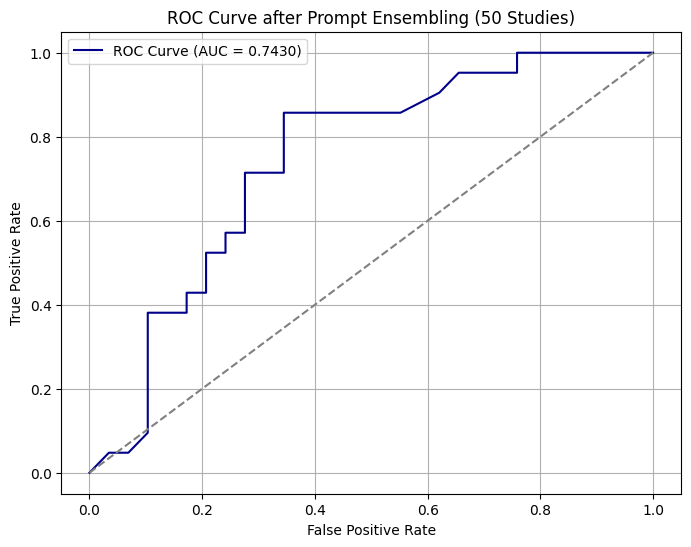

In [21]:
from matplotlib import pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(df_filtered["replicated"], df_filtered["replication_probability"])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color="darkblue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve after Prompt Ensembling (50 Studies)")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print("Number of studies used:", len(df_filtered))

Number of studies used: 50


In [ ]:
# damn didnt expect this much increase in auc... now I just need to get this number of studies used to 100.
# we take it.